<a href="https://colab.research.google.com/github/alexandrufiruti/masterlastyear/blob/main/mlav/face_landmark_localization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Proiect MLAV** -  Face (Eye) Landmarks localization
*   Baza de date: Caltech 10k Web Faces ([aici](http://www.vision.caltech.edu/Image_Datasets/Caltech_10K_WebFaces/))
*   Arhitectura : ResNet-18 (detalii [aici](https://www.youtube.com/watch?v=**ZILIbUvp5lk**))



Accesare date (daca nu exista deja local):


1.   Descarcare arhiva cu *wget*
2.   Dezarhivare
3.   Stergere arhiva dupa dezarhivare



In [1]:
import os

# descarcare imagini
!rm -r *
!wget http://www.ifp.illinois.edu/~vuongle2/helen/data/helen_1.zip
!wget http://www.ifp.illinois.edu/~vuongle2/helen/data/helen_2.zip
!wget http://www.ifp.illinois.edu/~vuongle2/helen/data/helen_3.zip
!wget http://www.ifp.illinois.edu/~vuongle2/helen/data/helen_4.zip
!wget http://www.ifp.illinois.edu/~vuongle2/helen/data/helen_5.zip
!unzip '*.zip' 1>/dev/null
!mkdir all_helen
!mv helen_*/* all_helen/
!rm -r helen_*
!echo "Numarul total de imagini (antrenare & testare):"
!ls all_helen | wc -l

# descarcare adnotari
!wget http://www.ifp.illinois.edu/~vuongle2/helen/data/annotation.zip
!unzip 'annotation.zip' 1>/dev/null
!rm -r annotation.zip
!ls annotation | wc -l



--2020-11-05 17:10:32--  http://www.ifp.illinois.edu/~vuongle2/helen/data/helen_1.zip
Resolving www.ifp.illinois.edu (www.ifp.illinois.edu)... 130.126.122.239
Connecting to www.ifp.illinois.edu (www.ifp.illinois.edu)|130.126.122.239|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 96876123 (92M) [application/zip]
Saving to: ‘helen_1.zip’

helen_1.zip         100%[===================>]  92.39M  59.3MB/s    in 1.6s    

2020-11-05 17:10:34 (59.3 MB/s) - ‘helen_1.zip’ saved [96876123/96876123]

--2020-11-05 17:10:34--  http://www.ifp.illinois.edu/~vuongle2/helen/data/helen_2.zip
Resolving www.ifp.illinois.edu (www.ifp.illinois.edu)... 130.126.122.239
Connecting to www.ifp.illinois.edu (www.ifp.illinois.edu)|130.126.122.239|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 106113055 (101M) [application/zip]
Saving to: ‘helen_2.zip’

helen_2.zip         100%[===================>] 101.20M  61.4MB/s    in 1.6s    

2020-11-05 17:10:36 (61.4 MB/s)

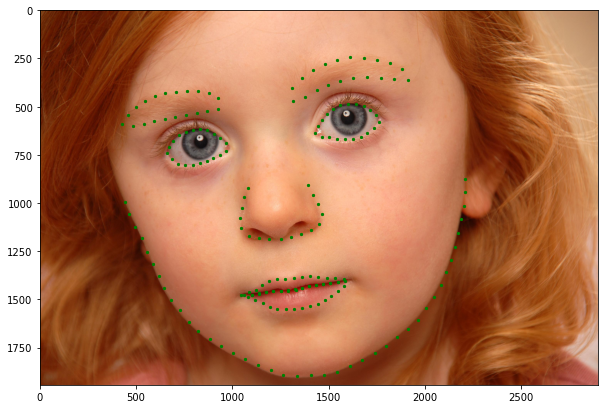

In [8]:
from skimage import io
import matplotlib.pyplot as plt
from math import floor
import numpy as np

landmark_dict = dict() # dictionar {key=nume_fisier, value=lista_puncte_landmark}
for filename in os.listdir('annotation'):
  with open("annotation/"+filename, 'r') as f:
    imagename = f.readline().rstrip('\n')
    content = f.readlines()
    points = []
    for point in content:
      temp = (point[:-1].split(" , "))
      points.append([floor(float(temp[0])), floor(float(temp[1]))])
    landmark_dict[imagename] = points
    

#images_dict = dict() # dictionar {key=nume_fisier, value=imaginea}
#for filename in os.listdir('all_helen'):
#  images_dict[filename[:-4]] = io.imread("all_helen/"+filename)# nume fara extensia .jpg

point = landmark_dict['3247810519_1']
point = np.array(point)

img = io.imread("all_helen/3247810519_1.jpg")
plt.figure(figsize=(10,10))
plt.imshow(img)
plt.scatter(point[:,0], point[:,1], s = 5, c = 'g')
plt.show()





--2020-11-05 17:22:50--  https://raw.githubusercontent.com/computationalcore/introduction-to-opencv/master/assets/haarcascade_frontalface_default.xml
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 930127 (908K) [text/plain]
Saving to: ‘haarcascade_frontalface_default.xml’

haarcascade_frontal 100%[===================>] 908.33K  --.-KB/s    in 0.08s   

2020-11-05 17:22:50 (11.8 MB/s) - ‘haarcascade_frontalface_default.xml’ saved [930127/930127]

[[ 307   36 1793 1793]]


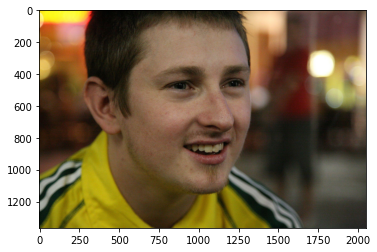

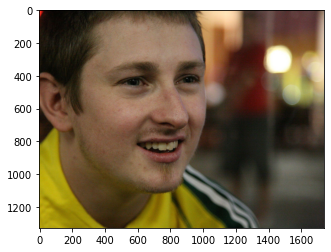

In [16]:
!wget --no-check-certificate \
    https://raw.githubusercontent.com/computationalcore/introduction-to-opencv/master/assets/haarcascade_frontalface_default.xml \
    -O haarcascade_frontalface_default.xml

import cv2
import torch

img = cv2.imread('all_helen/118736691_1.jpg')
landmarks = landmark_dict['118736691_1']
landmarks = np.array(landmarks)

face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
faces = face_cascade.detectMultiScale(gray)
print(faces)
(x,y,w,h) = faces[0]
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

crop_image = img[y:y+h, x:x+w]
#landmarks = torch.tensor(landmarks) - torch.tensor([[y, x]])
#landmarks = landmarks / torch.tensor([img.shape[1], img.shape[0]])
plt.imshow(cv2.cvtColor(crop_image, cv2.COLOR_BGR2RGB))
#plt.scatter(landmarks[:,0], landmarks[:,1], s = 5, c = 'g')
plt.show()

In [17]:
!pip install mtcnn

# sursa: https://github.com/ipazc/mtcnn

     |████████████████████████████████| 2.3MB 3.4MB/s 


343 204 335 469


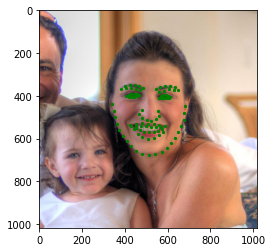

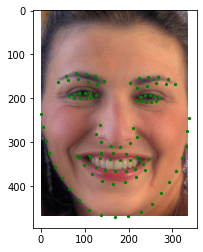

In [40]:
from mtcnn import MTCNN
import cv2

img = cv2.cvtColor(cv2.imread("all_helen/1218567979_2.jpg"), cv2.COLOR_BGR2RGB)
landmarks = landmark_dict['1218567979_2']
landmarks = np.array(landmarks)
landmarks = landmarks[::2, :] # pentru ca sunt prea multe se elimina jumatate din punctele de landmark  

detector = MTCNN()
[x,y, w, h] = detector.detect_faces(img)[0]['box']
print(x,y,w,h)

crop_image = img[y:y+h, x:x+w]
plt.imshow(img)
plt.scatter(landmarks[:,0], landmarks[:,1], s = 5, c = 'g')
plt.show()
plt.imshow(crop_image)

# actualizarea landmark dupa operatia de crop
landmarks = landmarks - [x,y]
plt.scatter(landmarks[:,0], landmarks[:,1], s = 5, c = 'g')
plt.show()